In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from load_img.baseimage import PETImage, normalize
from kmeans_segmentation import pca_kmeans_segmentation, fourier_kmeans_segmentation, apply_masks
from utility_functions import sparsifyDynamics, poolData

#### Some helpful functions

In [29]:
def disp_segment(seg, view_ax = 'y', col_t = 'sum', col_v = 'sum', figsize=(18, 16)):
    ax_ix = {'z':0,'y':1,'x':2,'t':3}[view_ax]
    
    frame = getattr(seg,col_t)(axis=3)
    
    img = getattr(frame,col_v)(axis=ax_ix)
    
    fig = plt.figure(figsize=figsize)
    plt.imshow(img,cmap='gray')
    plt.show()
    
    

    

#### Data from File

In [4]:
data_dir = 'data'
pet_files = [f for f in os.listdir(data_dir) if f.endswith('.pet.img') and not f.startswith('.')]
fname = pet_files[0]
fpath = os.path.join(data_dir,fname)
my_img = PETImage(filepath=fpath)
my_img.load_image()

File dimensions: (128,128,159,40)
Reading image data...


## Segment Image

#### Fourier Segmentation

Clustering image voxels...
Created 20 masks of image


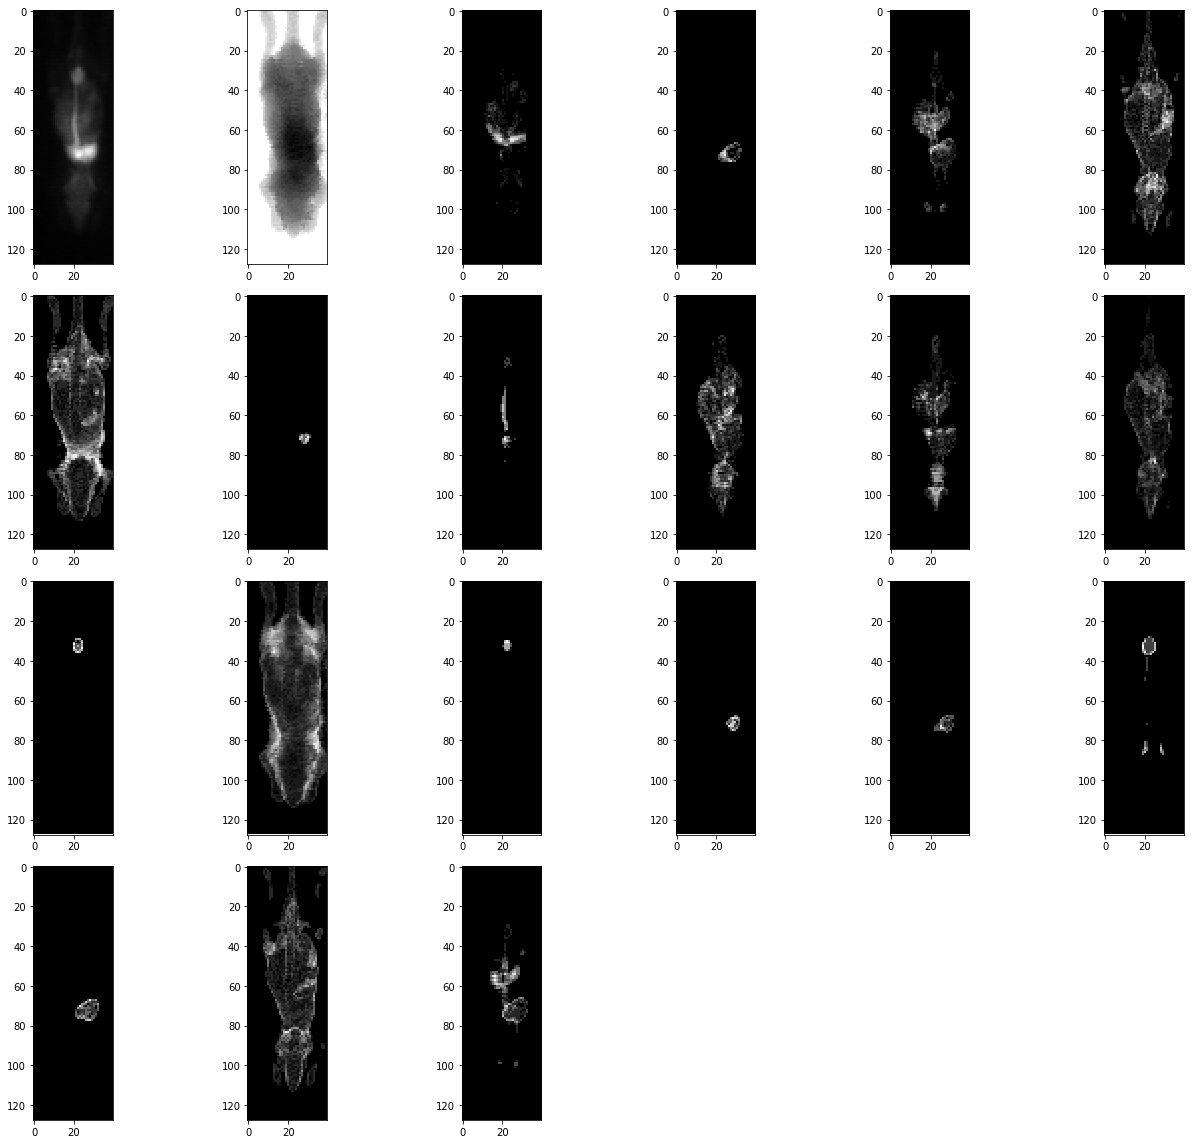

In [5]:
Ns = my_img.img_data.shape

# select the middle z=Ws[0],y=Ws[1],x=Ws[2] prism of each frame
Ws = (128,60,40)
roi_lims = [(int((N-W)/2),int((N+W)/2)) for N,W in zip(Ns,Ws)]

# select options for segmentation and run segmentation
print('Clustering image voxels...')
options = {
    'roi_lims' : roi_lims,
    'plot' : True,
    'fig_size' : (18, 16),
    'nfeatures' : 6,
    'nclusters' : 20
    }
masks, roi = fourier_kmeans_segmentation(my_img,**options)



#### Time series segmentation

Clustering image voxels...
Created 20 masks of image


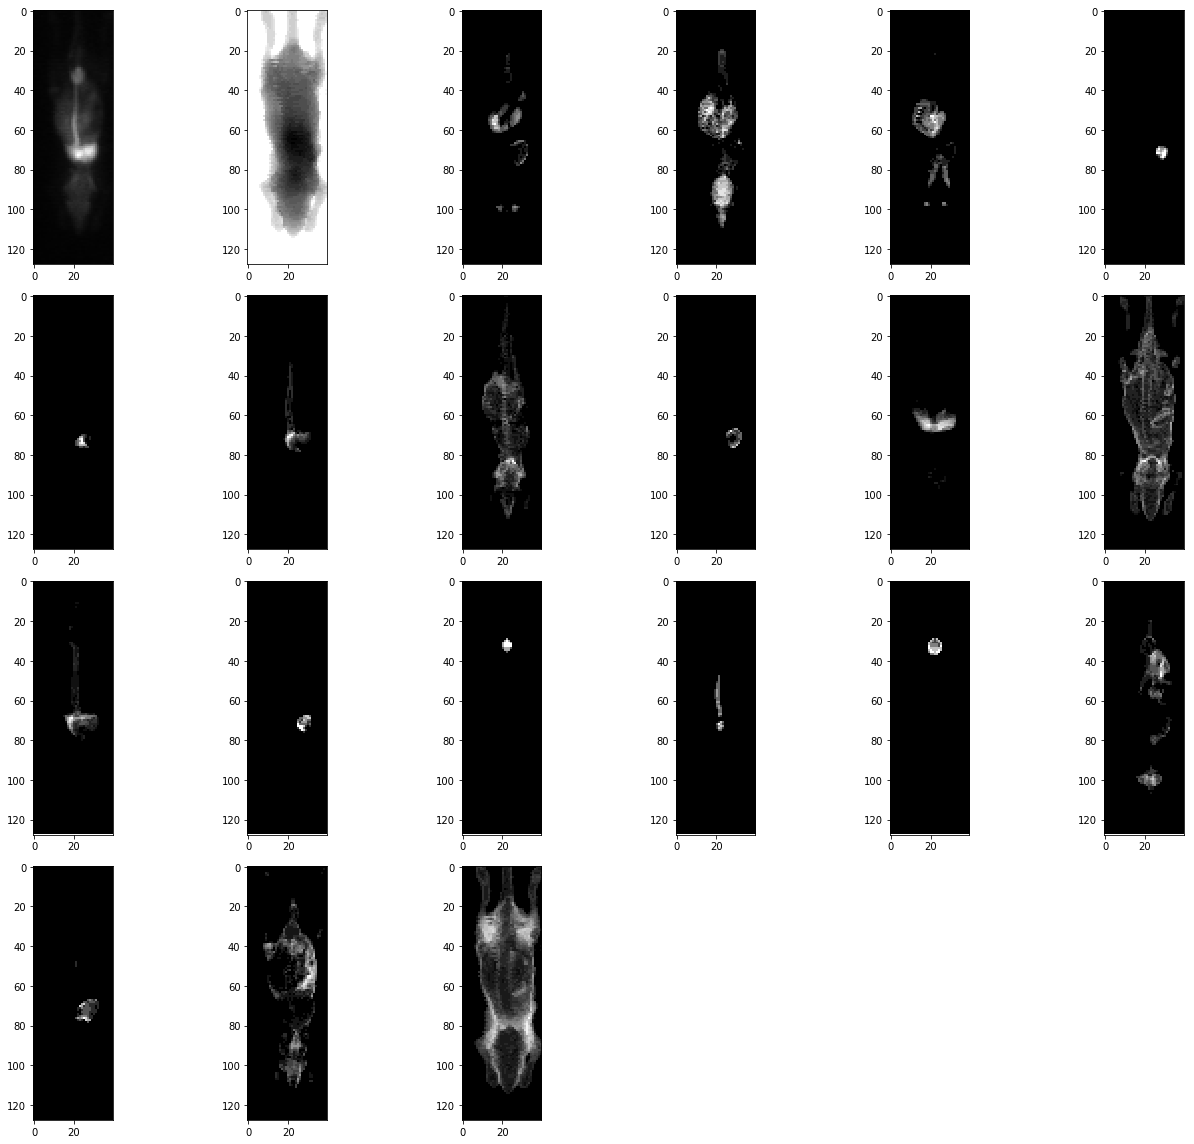

In [6]:
Ns = my_img.img_data.shape

# select the middle z=Ws[0],y=Ws[1],x=Ws[2] prism of each frame
Ws = (128,60,40)
roi_lims = [(int((N-W)/2),int((N+W)/2)) for N,W in zip(Ns,Ws)]

# select options for segmentation and run segmentation
print('Clustering image voxels...')
options = {
    'roi_lims' : roi_lims,
    'plot' : True,
    'fig_size' : (18, 16),
    'nfeatures' : 6,
    'nclusters' : 20
    }
masks, roi = pca_kmeans_segmentation(my_img,**options)

# done with original image data
my_img.unload_image()

#### apply masks to original ROI

In [7]:
# done with original image data
my_img.unload_image()

new_rois = apply_masks(masks,roi)

#### plot total intensity of each segment

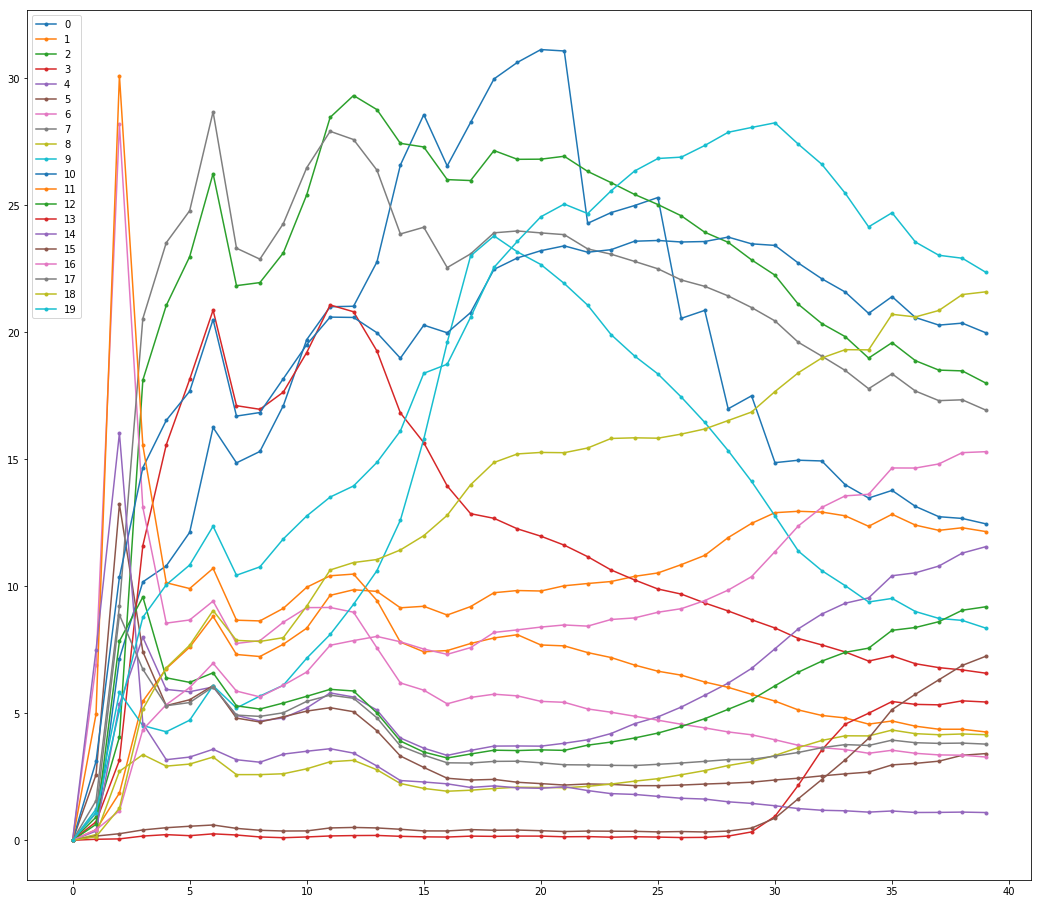

In [8]:
intensity_curves  = [mroi.reshape(Ws[0]*Ws[1]*Ws[2],Ns[-1]).sum(axis=0) for mroi in new_rois]
df = pd.DataFrame(data=np.stack(intensity_curves).T)
df.plot(figsize=(18, 16),marker='.')

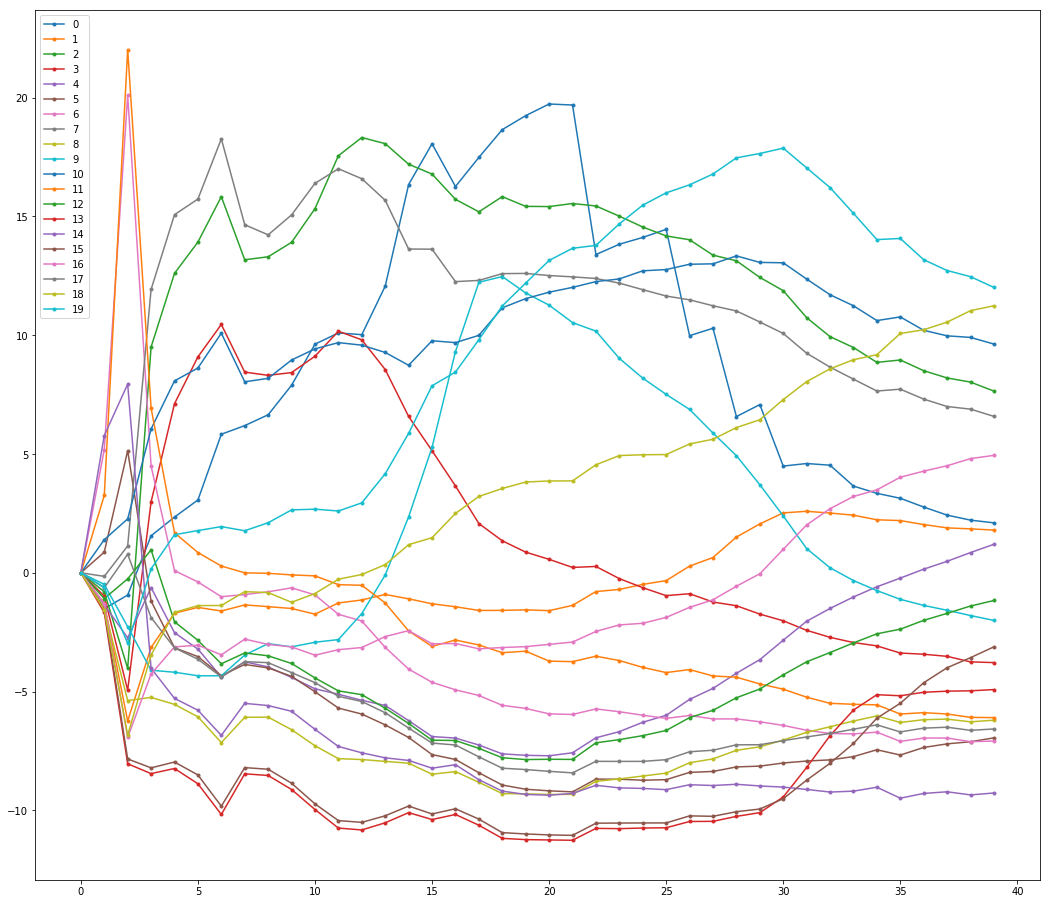

In [9]:
# subtract mean at each time point from corresponding intensities
sdf = df.subtract(df.mean(axis=1),axis=0)
sdf.plot(figsize=(18, 16),marker='.')

#### Pick some clusters

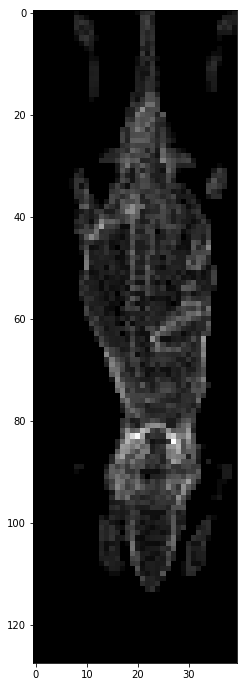

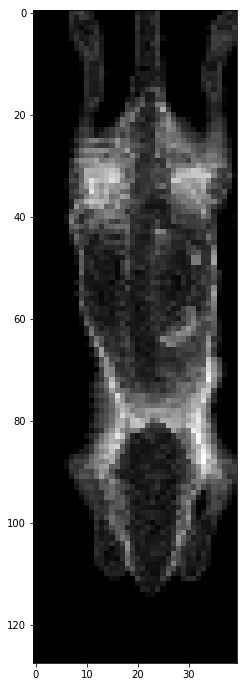

In [30]:
disp_segment(new_rois[10], figsize=(14,12))
disp_segment(new_rois[19], figsize=(14,12))

#### Get cluster data as df    

In [43]:
# since we lose a row in diff step,
# just use first N rows of df


# divide frame_duration
X = df[:-1].T
X_dot = df.diff()[1:].T

#### Get subdf with just the ixs of the clusters we want to analyze

In [34]:
ixs = [10,19]
tX = X[ixs]
tX_dot = X_dot[ixs]

#### Prepare SINDy

In [38]:
n,nVars = tX.shape

cols = ['x{}'.format(i+1) for i in range(nVars)]
tX.columns = cols
dot_labels = pd.Index([s + 'dot' for s in cols])

polyorder = 2
lam = 0.001
usesine = 0

Theta = poolData(tX,nVars, polyorder, usesine)

#### Run SINDy

In [40]:
Xhat_df = sparsifyDynamics(Theta,tX_dot,lam)
Xhat_df = Xhat_df.set_index(dot_labels)

In [ ]:
plt.title("Phase Plane Plot")
plt.xlabel("x1")
plt.ylabel("x2")
plt.plot(x1,x2)
plt.show()
plt.close()

In [41]:
Xhat_df

,0,x1,x2,"(x1, x1)","(x1, x2)","(x2, x2)"
x1dot,0.0,0.061000,0.001203,0.000000,0.000000,0.000996
x2dot,0.0,0.024469,-0.000000,-0.004755,0.005237,-0.001257


In [44]:
X.shape

(20, 39)

In [45]:
X.to_pickle(os.path.join('data','cluster_X_1.pkl'))

In [48]:
X_dot.to_pickle(os.path.join('data','cluster_Xdot_1.pkl'))

#### Show singular values

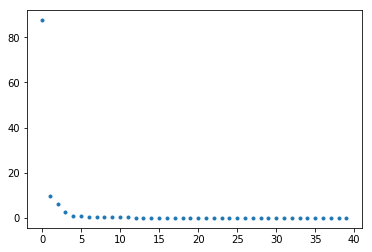

In [39]:
X = roi.reshape(128*60*40,40)
U,S,V = np.linalg.svd(X.T.dot(X))
plt.plot(np.arange(40),S,'.')